# Training Pipeline

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import sys
import os
import string
import random

In [36]:
CSV_FILE = 'merged_protein_dataset.csv'

In [26]:
class BioLiPDataset(Dataset):

    def _process_data(self):
        """Extract sequences and binding labels from all chains."""
        chain_letters = list(string.ascii_letters) + list('1234')

        for idx, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing sequences"):
            pdb_id = row['pdb_id']
            ligand_name = row['ligand_name']
            
            for chain in chain_letters:
                seq_col = f'chain_{chain}_sequence'
                binding_col = f'chain_{chain}_binding_array'
                length_col = f'chain_{chain}_length'
                
                if seq_col in row and pd.notna(row[seq_col]):
                    sequence = str(row[seq_col])
                    binding_array_str = str(row[binding_col])
                    
                    # Skip if sequence is too short or too long
                    if len(sequence) < self.min_length or len(sequence) > self.max_length:
                        continue
                    
                    try:
                        # Parse binding array string to list
                        binding_array = ast.literal_eval(binding_array_str)
                        
                        # Ensure binding array matches sequence length
                        if len(binding_array) != len(sequence):
                            continue
                            
                        self.sequences.append(sequence)
                        self.binding_labels.append(binding_array)
                        self.metadata.append({
                            'pdb_id': pdb_id,
                            'chain': chain,
                            'ligand_name': ligand_name,
                            'length': len(sequence)
                        })
                        
                    except (ValueError, SyntaxError):
                        # Skip malformed binding arrays
                        continue
        
        print(f"Processed {len(self.sequences)} sequences from {len(self.data)} PDB entries ({self.split} split)")
        print(f"Average sequence length: {np.mean([len(s) for s in self.sequences]):.1f}")
        print(f"Average binding site coverage: {np.mean([np.mean(labels) for labels in self.binding_labels])*100:.2f}%")

    def __init__(self, csv_file, max_length=1000, min_length=20, split='train', test_size=0.1, random_seed=42):
        """
        Args:
            csv_file: Path to BioLiP CSV file
            max_length: Maximum sequence length (truncate longer sequences)
            min_length: Minimum sequence length (filter shorter sequences)
            split: 'train', 'test', or 'all' - which split to load
            test_size: Fraction of PDB entries to reserve for testing (default 0.1 = 10%)
            random_seed: Random seed for reproducible splits
        """
        # Load full dataset
        full_data = pd.read_csv(csv_file)
        
        # Split at PDB entry level to prevent data leakage
        unique_pdb_ids = full_data['pdb_id'].unique()
        
        # Create train/test split of PDB IDs
        np.random.seed(random_seed)
        test_pdb_ids = np.random.choice(unique_pdb_ids, 
                                       size=int(len(unique_pdb_ids) * test_size), 
                                       replace=False)
        train_pdb_ids = np.setdiff1d(unique_pdb_ids, test_pdb_ids)
        
        # Filter data based on split
        if split == 'train':
            self.data = full_data[full_data['pdb_id'].isin(train_pdb_ids)].reset_index(drop=True)
            self.split = 'train'
        elif split == 'test':
            self.data = full_data[full_data['pdb_id'].isin(test_pdb_ids)].reset_index(drop=True)
            self.split = 'test'
        elif split == 'all':
            self.data = full_data
            self.split = 'all'
        else:
            raise ValueError("split must be 'train', 'test', or 'all'")
        
        print(f"Dataset split info:")
        print(f"  Total PDB entries: {len(unique_pdb_ids)}")
        print(f"  Train PDB entries: {len(train_pdb_ids)} ({len(train_pdb_ids)/len(unique_pdb_ids)*100:.1f}%)")
        print(f"  Test PDB entries: {len(test_pdb_ids)} ({len(test_pdb_ids)/len(unique_pdb_ids)*100:.1f}%)")
        print(f"  Loading: {split} split ({len(self.data)} rows)")
        
        self.max_length = max_length
        self.min_length = min_length
        
        # Amino acid to index mapping
        self.aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '<PAD>': 20, '<UNK>': 21
        }
        
        # Extract all chain sequences and binding labels
        self.sequences = []
        self.binding_labels = []
        self.metadata = []
        
        self._process_data()
        
    def get_pdb_ids(self):
        """Return list of PDB IDs in this split."""
        return list(self.data['pdb_id'].unique())
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        binding_labels = self.binding_labels[idx]
        
        # Convert sequence to indices
        seq_indices = [self.aa_to_idx.get(aa, self.aa_to_idx['<UNK>']) for aa in sequence]
        
        return {
            'sequence': torch.tensor(seq_indices, dtype=torch.long),
            'labels': torch.tensor(binding_labels, dtype=torch.float),
            'length': len(sequence),
            'metadata': self.metadata[idx]
        }

In [3]:
class ResidualConvBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + residual)  # Skip connection!
    
class SelfAttention1D(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        # x: (B, channels, L) -> (B, L, channels)
        x = x.transpose(1, 2)
        attn_out, _ = self.attention(x, x, x)
        x = self.norm(x + attn_out)  # Residual connection
        return x.transpose(1, 2)  # Back to (B, channels, L)

# Your existing CNN model (with small modifications)
class FastCNNBindingPredictor(nn.Module):
    def __init__(self, 
                 vocab_size: int = 22,
                 embed_dim: int = 64,
                 hidden_dim: int = 128,
                 dropout: float = 0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=20)
        
        # Multi-scale dilated convolutions
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embed_dim, hidden_dim//4, kernel_size=3, dilation=1, padding=1),
            nn.Conv1d(embed_dim, hidden_dim//4, kernel_size=5, dilation=1, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//4, kernel_size=3, dilation=2, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//4, kernel_size=3, dilation=4, padding=4),
        ])

        self.res_blocks = nn.Sequential(
            ResidualConvBlock(hidden_dim, dropout),
            ResidualConvBlock(hidden_dim, dropout),
            ResidualConvBlock(hidden_dim, dropout),  # 3 residual blocks
        )

        self.attention = SelfAttention1D(hidden_dim)
        
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Binary classification head - per-residue binding prediction
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1),  # Not kernel=1
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim//2, hidden_dim//4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim//4, 1, kernel_size=1)
        )
        
    def forward(self, x, mask=None):
        # Embedding
        x = self.embedding(x)
        x = x.transpose(1, 2)
        
        # Multi-scale convolutions (keep your current code)
        conv_outputs = []
        for conv in self.conv_layers:
            conv_out = F.relu(conv(x))
            conv_outputs.append(conv_out)
        
        x = torch.cat(conv_outputs, dim=1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        
        # NEW: Add residual blocks
        x = self.res_blocks(x)
        
        # NEW: Add attention
        x = self.attention(x)
        
        # Classification (with better head)
        x = self.classifier(x).squeeze(1)
        
        if mask is not None:
            x = x * mask.float()
        
        return x
    

In [ ]:
#Enhanced CNN Model
class ResidualConvBlock(nn.Module):
    def __init__(self, channels, dropout=0.1, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.conv3 = nn.Conv1d(channels, channels, 1)  # 1x1 conv for feature mixing
        
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)
        self.bn3 = nn.BatchNorm1d(channels)
        
        self.dropout = nn.Dropout(dropout)
        self.se = SqueezeExcitation(channels, reduction=8)
        
    def forward(self, x):
        residual = x
        
        # First conv block
        x = F.gelu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        # Second conv block
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        # 1x1 conv for feature refinement
        x = self.bn3(self.conv3(x))
        
        # Squeeze-and-Excitation
        x = self.se(x)
        
        # Residual connection
        return F.gelu(x + residual)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Conv1d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv1d(channels // reduction, channels, kernel_size=1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        attention = torch.sigmoid(avg_out + max_out)
        return x * attention

class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Conv1d(channels, channels // reduction, kernel_size=1),
            nn.GELU(),
            nn.Conv1d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        squeezed = self.squeeze(x)
        excited = self.excitation(squeezed)
        return x * excited

class SelfAttention1D(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        # x: (B, channels, L) -> (B, L, channels)
        x = x.transpose(1, 2)
        
        # Self-attention with residual
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out)
        
        # Feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x.transpose(1, 2)  # Back to (B, channels, L)

class EnhancedCNNBindingPredictor(nn.Module):
    def __init__(self, 
                 vocab_size: int = 22,
                 embed_dim: int = 128,        # Doubled from 64
                 hidden_dim: int = 512,       # 4x increase from 128
                 num_residual_blocks: int = 8, # More residual blocks
                 dropout: float = 0.1):
        super().__init__()
        
        # Larger embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=20)
        
        # More comprehensive multi-scale dilated convolutions
        self.conv_layers = nn.ModuleList([
            # Original scales
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=1, padding=1),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=5, dilation=1, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=7, dilation=1, padding=3),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=9, dilation=1, padding=4),
            # More dilation scales
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=2, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=4, padding=4),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=8, padding=8),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=16, padding=16),
        ])
        
        # Deeper residual tower
        self.res_blocks = nn.ModuleList([
            ResidualConvBlock(hidden_dim, dropout, kernel_size=3),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=5),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=3),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=7),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=3),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=3),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=5),
            ResidualConvBlock(hidden_dim, dropout, kernel_size=3),
        ])
        
        # Multiple attention heads at different scales
        self.attention_layers = nn.ModuleList([
            SelfAttention1D(hidden_dim, num_heads=8),
            SelfAttention1D(hidden_dim, num_heads=16),
            SelfAttention1D(hidden_dim, num_heads=32),
        ])
        
        # Channel attention for feature refinement
        self.channel_attention = ChannelAttention(hidden_dim * 4)  # 4 because we concat 3 attention + original
        
        # Squeeze-and-Excitation blocks for better feature recalibration
        self.se_blocks = nn.ModuleList([
            SqueezeExcitation(hidden_dim * 4, reduction=16),
            SqueezeExcitation(hidden_dim * 4, reduction=8),
        ])
        
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Much deeper and wider classification head
        self.classifier = nn.Sequential(
            # First stage
            nn.Conv1d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            
            # Second stage
            nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            
            # Third stage
            nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout),
            
            # Fourth stage
            nn.Conv1d(hidden_dim//2, hidden_dim//4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Dropout(dropout),
            
            # Fifth stage
            nn.Conv1d(hidden_dim//4, hidden_dim//8, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//8),
            nn.GELU(),
            nn.Dropout(dropout),
            
            # Final prediction
            nn.Conv1d(hidden_dim//8, 1, kernel_size=1)
        )
        
    def forward(self, x, mask=None):
        # Embedding
        x = self.embedding(x)  # (B, L, embed_dim)
        x = x.transpose(1, 2)  # (B, embed_dim, L)
        
        # Multi-scale convolutions
        conv_outputs = []
        for conv in self.conv_layers:
            conv_out = F.gelu(conv(x))  # Using GELU instead of ReLU
            conv_outputs.append(conv_out)
        
        x = torch.cat(conv_outputs, dim=1)  # (B, hidden_dim, L)
        x = self.batch_norm(x)
        x = self.dropout(x)
        
        # Deep residual processing with skip connections
        residual_input = x
        for i, res_block in enumerate(self.res_blocks):
            x = res_block(x)
            
            # Add skip connections every 2 blocks
            if i % 2 == 1 and i > 0:
                x = x + residual_input
                residual_input = x
        
        # Multi-scale attention
        attention_outputs = []
        for attention_layer in self.attention_layers:
            att_out = attention_layer(x)
            attention_outputs.append(att_out)
        
        # Concatenate all attention outputs with original
        x_with_attention = torch.cat(attention_outputs + [x], dim=1)  # (B, hidden_dim*4, L)
        
        # Channel attention
        x_with_attention = self.channel_attention(x_with_attention)
        
        # Squeeze-and-Excitation blocks
        for se_block in self.se_blocks:
            x_with_attention = se_block(x_with_attention)
        
        # Deep classification
        x = self.classifier(x_with_attention).squeeze(1)  # (B, L)
        
        if mask is not None:
            x = x * mask.float()
        
        return x

In [37]:
# Create the enhanced model - commented out
#model = EnhancedFastCNNBindingPredictor(
#    embed_dim=128,      # 2x original
#    hidden_dim=512,     # 4x original  
#    num_residual_blocks=8,
#    dropout=0.1
#).to(device)
#
#print(f'Enhanced model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M')
# Expect 15-25M parameters vs ~2-3M in original


In [ ]:
class TransformerCNNBindingPredictor(nn.Module):
    def __init__(self, 
                 vocab_size: int = 22,
                 embed_dim: int = 256,      # Much larger
                 hidden_dim: int = 512,     # Much larger
                 num_transformer_layers: int = 8,
                 num_attention_heads: int = 16,
                 dropout: float = 0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=20)
        self.pos_encoding = nn.Parameter(torch.randn(1000, embed_dim))  # Positional encoding
        
        # Multi-scale CNN feature extraction (keep your good design)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=1, padding=1),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=5, dilation=1, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=7, dilation=1, padding=3),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=2, padding=2),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=4, padding=4),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=8, padding=8),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=16, padding=16),
            nn.Conv1d(embed_dim, hidden_dim//8, kernel_size=3, dilation=32, padding=32),
        ])
        
        # Project to transformer dimension
        self.cnn_to_transformer = nn.Linear(hidden_dim, embed_dim)
        
        # Transformer layers for long-range dependencies
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_attention_heads,
            dim_feedforward=embed_dim * 4,  # Large FFN
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_transformer_layers)
        
        # More residual blocks
        self.res_blocks = nn.Sequential(*[
            ResidualConvBlock(embed_dim, dropout) for _ in range(6)  # 6 blocks instead of 3
        ])
        
        # Multi-head attention with different scales
        self.multi_scale_attention = nn.ModuleList([
            SelfAttention1D(embed_dim, num_heads=8),
            SelfAttention1D(embed_dim, num_heads=16),
            SelfAttention1D(embed_dim, num_heads=32),
        ])
        
        # Deep classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(embed_dim * 4, hidden_dim, kernel_size=3, padding=1),  # 4x channels from multi-scale attention
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim//2, hidden_dim//4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim//4, 1, kernel_size=1)
        )
        
    def forward(self, x, mask=None):
        batch_size, seq_len = x.shape
        
        # Embedding with positional encoding
        x = self.embedding(x)  # (B, L, embed_dim)
        x = x + self.pos_encoding[:seq_len].unsqueeze(0)  # Add positional encoding
        
        # CNN feature extraction
        x_cnn = x.transpose(1, 2)  # (B, embed_dim, L)
        conv_outputs = []
        for conv in self.conv_layers:
            conv_out = F.gelu(conv(x_cnn))
            conv_outputs.append(conv_out)
        
        x_cnn = torch.cat(conv_outputs, dim=1)  # (B, hidden_dim, L)
        x_cnn = x_cnn.transpose(1, 2)  # (B, L, hidden_dim)
        
        # Project CNN features to transformer dimension
        x_cnn = self.cnn_to_transformer(x_cnn)  # (B, L, embed_dim)
        
        # Combine with original embeddings
        x_combined = x + x_cnn  # Residual connection
        
        # Transformer layers for global context
        if mask is not None:
            # Create attention mask for transformer
            transformer_mask = ~mask.bool()  # Invert mask for transformer
        else:
            transformer_mask = None
            
        x_transformer = self.transformer(x_combined, src_key_padding_mask=transformer_mask)
        
        # Convert back to CNN format
        x = x_transformer.transpose(1, 2)  # (B, embed_dim, L)
        
        # Residual blocks
        x = self.res_blocks(x)
        
        # Multi-scale attention
        attention_outputs = []
        for attention_layer in self.multi_scale_attention:
            att_out = attention_layer(x)
            attention_outputs.append(att_out)
        
        # Concatenate attention outputs
        x = torch.cat(attention_outputs + [x], dim=1)  # (B, embed_dim*4, L)
        
        # Deep classification
        x = self.classifier(x).squeeze(1)  # (B, L)
        
        if mask is not None:
            x = x * mask.float()
        
        return x

In [5]:
def collate_fn(batch):
    """Custom collate function to handle variable length sequences."""
    sequences = [item['sequence'] for item in batch]
    labels = [item['labels'] for item in batch]
    lengths = [item['length'] for item in batch]
    metadata = [item['metadata'] for item in batch]
    
    # Pad sequences
    max_len = max(lengths)
    padded_sequences = []
    padded_labels = []
    masks = []
    
    for seq, label in zip(sequences, labels):
        pad_len = max_len - len(seq)
        
        # Pad sequence
        padded_seq = F.pad(seq, (0, pad_len), value=20)  # PAD token = 20
        padded_sequences.append(padded_seq)
        
        # Pad labels
        padded_label = F.pad(label, (0, pad_len), value=0)  # Pad with 0 (non-binding)
        padded_labels.append(padded_label)
        
        # Create mask (1 for real tokens, 0 for padding)
        mask = torch.cat([torch.ones(len(seq)), torch.zeros(pad_len)])
        masks.append(mask)
    
    return {
        'sequences': torch.stack(padded_sequences),
        'labels': torch.stack(padded_labels),
        'masks': torch.stack(masks),
        'lengths': torch.tensor(lengths),
        'metadata': metadata
    }

# Training utilities
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance (many more non-binding than binding residues)."""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets, mask=None):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        
        if mask is not None:
            focal_loss = focal_loss * mask
            if self.reduction == 'mean':
                return focal_loss.sum() / mask.sum()
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

def calculate_metrics(predictions, labels, masks):
    """Calculate evaluation metrics."""
    # Flatten and apply masks
    pred_flat = predictions[masks.bool()].cpu().numpy()
    label_flat = labels[masks.bool()].cpu().numpy()
    
    # Convert predictions to binary
    pred_binary = (pred_flat > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(label_flat, pred_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(label_flat, pred_binary, average='binary')
    
    try:
        auc = roc_auc_score(label_flat, pred_flat)
    except ValueError:
        auc = 0.0  # Handle case where all labels are same class
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def compute_pos_weight(train_loader):
    """Calculate positive class weight for imbalanced data"""
    total_pos = 0
    total_neg = 0
    
    for batch in train_loader:
        # FIX: Access dictionary keys
        targets = batch['labels']
        masks = batch['masks']
        
        masked_targets = targets[masks.bool()]
        total_pos += masked_targets.sum().item()
        total_neg += (masked_targets == 0).sum().item()
    
    pos_weight = total_neg / total_pos if total_pos > 0 else 1.0
    return torch.tensor([pos_weight])

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        
    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = val_score
            self.counter = 0
        return False

# Training function
def train_model(train_loader, val_loader, model, device, num_epochs=50, lr=1e-3):
    """Training loop for the binding site prediction model."""
    VALIDATION_STEPS = 100
    LEARNING_RATE = 2e-4
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=LEARNING_RATE,
        weight_decay=1e-4,  # L2 regularization
        betas=(0.9, 0.999)
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    train_losses = []
    val_f1_scores = []
    best_val_f1 = 0.0

    pos_weight = compute_pos_weight(train_loader)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch in progress_bar:
            sequences = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            masks = batch['masks'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences, masks)
            
            masked_outputs = outputs[masks.bool()]
            masked_labels = labels[masks.bool()]
            loss = criterion(masked_outputs, masked_labels)
            
            # Backward pass
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        #FIXED VALIDATION PHASE
        model.eval()
        all_predictions = []
        all_labels = []
        all_masks = []
        
        with torch.no_grad():
            for batch in val_loader:
                sequences = batch['sequences'].to(device)
                labels = batch['labels'].to(device)
                masks = batch['masks'].to(device)
                
                outputs = model(sequences, masks)
                predictions = torch.sigmoid(outputs)
                
                # Flatten each batch and only keep non-padded positions
                batch_size, seq_len = predictions.shape
                for i in range(batch_size):
                    actual_length = int(masks[i].sum().item())
                    # Only keep the actual sequence (non-padded part)
                    all_predictions.extend(predictions[i, :actual_length].cpu().numpy())
                    all_labels.extend(labels[i, :actual_length].cpu().numpy())
                    all_masks.extend([1] * actual_length)  # All are valid positions
        
        # Convert to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_masks = np.array(all_masks)
        
        # Calculate validation metrics
        val_metrics = calculate_metrics_numpy(all_predictions, all_labels, all_masks)
        val_f1_scores.append(val_metrics['f1'])

                
        # Learning rate scheduling
        scheduler.step(val_metrics['f1'])


        # Save best model
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_val_f1,
            }, 'best_binding_model.pth')

        if early_stopping(val_metrics['f1']):
            print("Early stopping triggered")
            break

    
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Accuracy: {val_metrics["accuracy"]:.4f}')
        print(f'  Val Precision: {val_metrics["precision"]:.4f}')
        print(f'  Val Recall: {val_metrics["recall"]:.4f}')
        print(f'  Val F1: {val_metrics["f1"]:.4f}')
        print(f'  Val AUC: {val_metrics["auc"]:.4f}')
        print(f'  Best Val F1: {best_val_f1:.4f}')
        print('-' * 50)
    
    return train_losses, val_f1_scores

def calculate_metrics_numpy(predictions, labels, masks):
    """Calculate evaluation metrics for numpy arrays."""
    # Convert predictions to binary
    pred_binary = (predictions > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, pred_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_binary, average='binary')
    
    try:
        auc = roc_auc_score(labels, predictions)
    except ValueError:
        auc = 0.0  # Handle case where all labels are same class
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

In [35]:
def main():
    #FAST TRAINING CONFIGURATION
    BATCH_SIZE = 32
    MAX_LENGTH = 300
    MIN_LENGTH = 20
    NUM_EPOCHS = 10
    LEARNING_RATE = 2e-4
    
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Load dataset
    print('Loading dataset...')
    dataset = BioLiPDataset(CSV_FILE, max_length=MAX_LENGTH, min_length=MIN_LENGTH, split='train')
    
    #Use subset of data
    set_size = len(dataset)
    set_indices = list(range(set_size))

    without_binding = [i for i in set_indices if sum(dataset.binding_labels[i]) == 0]
    with_binding = [i for i in set_indices if sum(dataset.binding_labels[i]) > 0]

    test_samples_without_binding = random.sample(without_binding, min(5000, len(without_binding)))
    test_samples_with_binding = random.sample(with_binding, min(10000, len(with_binding)))

    test_indices = test_samples_without_binding + test_samples_with_binding

    # Create stratification labels BEFORE creating subset
    stratify_labels = [int(np.mean(dataset.binding_labels[i]) > 0.1) for i in test_indices]
    
    # Split the subset indices
    train_indices, val_indices = train_test_split(
        test_indices, 
        test_size=0.2, 
        random_state=42,
        stratify=stratify_labels
    )
    
    # Create datasets using the split indices
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    print(f'Using subset of {len(train_dataset) + len(val_dataset)} sequences for fast training')
    print(f'Train samples: {len(train_dataset)}')
    print(f'Validation samples: {len(val_dataset)}')
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=0
    )
    
    # Initialize smaller, faster model
    model = FastCNNBindingPredictor(
        embed_dim=64,
        hidden_dim=128,
        dropout=0.1
    ).to(device)
    
    print(f'Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M')

    pos_weight = compute_pos_weight(train_loader)
    print(f"Positive class weight: {pos_weight.item():.2f}")
    

    # Train model
    print('Starting training...')
    train_losses, val_f1_scores = train_model(
        train_loader, val_loader, model, device, 
        num_epochs=NUM_EPOCHS, lr=LEARNING_RATE
    )
    
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores)
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    print('Training completed!')
    print(f'Best validation F1 score: {max(val_f1_scores):.4f}')

In [28]:
if __name__ == '__main__':
    main()

Using device: mps
Loading dataset...


/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/3869039191.py:60: DtypeWarning: Columns (163,165,166,167,205,207,208,209,211,213,214,215,217,219,220,221,223,225,226,227,229,231,232,233,235,237,238,239,247,249,250,251,259,261,262,263,265,267,268,269,271,273,274,275,277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,302,304,305,306,308,309,310,311,312,314,315,317,318,319,320,321,322,324,329,332,333,334,335,336,337,339,341,342,343,345,346,348,350,351,352,353,355,356,359,361,362,363,365,367,368,369,372,373,374,376,377,378,379,382,383,385) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv(csv_file)


Dataset split info:
  Total PDB entries: 14955
  Train PDB entries: 13460 (90.0%)
  Test PDB entries: 1495 (10.0%)
  Loading: train split (36451 rows)


Processing sequences: 100%|██████████| 36451/36451 [00:13<00:00, 2636.16it/s]


Processed 59586 sequences from 36451 PDB entries (train split)
Average sequence length: 190.2
Average binding site coverage: 2.07%
Using subset of 15000 sequences for fast training
Train samples: 12000
Validation samples: 3000
Model parameters: 0.43M
Positive class weight: 22.42
Starting training...


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10:  14%|█▎        | 51/375 [01:35<10:04,  1.87s/it, Loss=1.1272] 


KeyboardInterrupt: 

# Evaluation/Test

In [14]:
AA_TO_IDX = {
    'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
    'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
    'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '<PAD>': 20, '<UNK>': 21
}

In [ ]:
def load_trained_model(model_path='best_binding_model.pth', device='mps'):
    """Load the trained binding site prediction model."""
    
    # Initialize model with same architecture as training
    model = FastCNNBindingPredictor(
        embed_dim=64,      # Same as training
        hidden_dim=128,    # Same as training  
        dropout=0.1
    )
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Loaded model with validation F1: {checkpoint['val_f1']:.4f}")
    return model

def sequence_to_tensor(sequence):
    """Convert amino acid sequence to tensor."""
    AA_TO_IDX = {
        'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
        'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
        'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '<PAD>': 20, '<UNK>': 21
    }
    
    indices = [AA_TO_IDX.get(aa.upper(), AA_TO_IDX['<UNK>']) for aa in sequence]
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0)  # Add batch dimension

def predict_binding_sites(model, protein_sequence, threshold=0.5, device='mps'):
    """
    Predict binding sites for a protein sequence.
    
    Args:
        model: Trained FastCNNBindingPredictor model
        protein_sequence: String of amino acids (e.g., "MKVLWAALLVTFLAG...")
        threshold: Probability threshold for calling a site "binding" (default 0.5)
        device: 'cpu' or 'mps'
    
    Returns:
        Dictionary with predictions and binding regions
    """
    
    # Convert sequence to tensor
    seq_tensor = sequence_to_tensor(protein_sequence).to(device)
    
    # Create mask (all positions are valid for single sequence)
    mask = torch.ones_like(seq_tensor, dtype=torch.float).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(seq_tensor, mask)
        probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
    
    # Find binding regions
    binding_regions = []
    binding_residues = []
    
    for i, (aa, prob) in enumerate(zip(protein_sequence, probabilities)):
        if prob > threshold:
            binding_residues.append({
                'position': i + 1,  # 1-indexed
                'amino_acid': aa,
                'binding_probability': float(prob)
            })
    
    # Group consecutive binding residues into regions
    if binding_residues:
        regions = []
        current_region = [binding_residues[0]]
        
        for residue in binding_residues[1:]:
            # If consecutive positions, add to current region
            if residue['position'] - current_region[-1]['position'] == 1:
                current_region.append(residue)
            else:
                # Start new region
                regions.append(current_region)
                current_region = [residue]
        
        regions.append(current_region)  # Don't forget the last region
        
        # Format regions
        for region in regions:
            start_pos = region[0]['position']
            end_pos = region[-1]['position']
            avg_prob = np.mean([r['binding_probability'] for r in region])
            sequence_fragment = ''.join([r['amino_acid'] for r in region])
            
            binding_regions.append({
                'start_position': start_pos,
                'end_position': end_pos,
                'sequence': sequence_fragment,
                'length': len(region),
                'average_probability': float(avg_prob),
                'max_probability': float(max(r['binding_probability'] for r in region))
            })
    
    return {
        'sequence': protein_sequence,
        'sequence_length': len(protein_sequence),
        'per_residue_scores': probabilities.tolist(),
        'binding_residues': binding_residues,
        'binding_regions': binding_regions,
        'num_binding_residues': len(binding_residues),
        'binding_coverage': len(binding_residues) / len(protein_sequence)
    }

def visualize_binding_prediction(result, show_probabilities=True):
    """Print a nice visualization of the binding prediction."""
    
    sequence = result['sequence']
    scores = result['per_residue_scores']
    
    print(f"Protein sequence ({result['sequence_length']} residues):")
    print(f"Predicted binding coverage: {result['binding_coverage']*100:.1f}%")
    print(f"Number of binding regions: {len(result['binding_regions'])}")
    print("-" * 80)
    
    # Print sequence with binding indicators
    print("Sequence:")
    for i in range(0, len(sequence), 60):  # 60 residues per line
        chunk = sequence[i:i+60]
        pos_start = i + 1
        pos_end = min(i + 60, len(sequence))
        
        print(f"{pos_start:>4}-{pos_end:<4}: {chunk}")
        
        if show_probabilities:
            # Show binding probabilities below
            prob_line = ""
            for j, aa in enumerate(chunk):
                prob = scores[i + j]
                if prob > 0.7:
                    prob_line += "█"  # High confidence binding
                elif prob > 0.5:
                    prob_line += "▓"  # Medium confidence binding  
                elif prob > 0.3:
                    prob_line += "░"  # Low confidence binding
                else:
                    prob_line += " "  # Non-binding
            print(f"          {prob_line}")
        print()
    
    # Print binding regions summary
    if result['binding_regions']:
        print("Predicted Binding Regions:")
        print("-" * 50)
        for i, region in enumerate(result['binding_regions'], 1):
            print(f"Region {i}: positions {region['start_position']}-{region['end_position']}")
            print(f"  Sequence: {region['sequence']}")
            print(f"  Length: {region['length']} residues")
            print(f"  Average probability: {region['average_probability']:.3f}")
            print(f"  Max probability: {region['max_probability']:.3f}")
            print()



In [33]:
class ModelEvaluator:
    def __init__(self, model, device, dataset, aa_to_idx=None):

        self.model = model
        self.device = device
        self.dataset = dataset
        self.aa_to_idx = aa_to_idx or AA_TO_IDX
        
        # Results storage
        self.results = {
            'true_binding_probs': [],
            'true_nonbinding_probs': [],
            'sequences_with_binding': [],
            'sequences_without_binding': [],
            'all_predictions': [],
            'all_labels': [],
            'sequence_level_metrics': []
        }
    
    def evaluate_dataset_subset(self, subset_size=1000, random_seed=42):
        """Evaluate model on a subset of the dataset."""
        print(f"Evaluating on {subset_size} sequences...")
        
        # Sample sequences
        np.random.seed(random_seed)
        indices = np.random.choice(len(self.dataset), size=min(subset_size, len(self.dataset)), replace=False)
        
        self.model.eval()
        with torch.no_grad():
            for i, idx in enumerate(tqdm(indices, desc="Evaluating sequences")):
                sequence_data = self.dataset[idx]
                sequence = sequence_data['sequence']
                true_labels = sequence_data['labels'].numpy()
                
                # Get prediction
                seq_tensor = sequence.unsqueeze(0).to(self.device)
                mask = torch.ones_like(seq_tensor, dtype=torch.float).to(self.device)
                
                outputs = self.model(seq_tensor, mask)
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
                
                # Store results
                self._store_sequence_results(true_labels, probs, idx)
        
        print(f"Evaluation complete! Analyzed {len(indices)} sequences.")
        return self._compute_comprehensive_metrics()
    
    def _store_sequence_results(self, true_labels, probs, sequence_idx):
        """Store results for a single sequence."""
        # Separate binding vs non-binding probabilities
        binding_mask = true_labels == 1
        nonbinding_mask = true_labels == 0
        
        self.results['true_binding_probs'].extend(probs[binding_mask])
        self.results['true_nonbinding_probs'].extend(probs[nonbinding_mask])
        self.results['all_predictions'].extend(probs)
        self.results['all_labels'].extend(true_labels)
        
        # Sequence-level analysis
        has_binding = np.sum(true_labels) > 0
        sequence_metrics = {
            'sequence_idx': sequence_idx,
            'has_true_binding': has_binding,
            'num_true_binding': int(np.sum(true_labels)),
            'sequence_length': len(true_labels),
            'predicted_binding_coverage': float(np.mean(probs > 0.5)),
            'max_predicted_prob': float(np.max(probs)),
            'mean_predicted_prob': float(np.mean(probs)),
            'false_positive_rate': float(np.mean(probs[nonbinding_mask] > 0.5)) if np.sum(nonbinding_mask) > 0 else 0.0
        }
        
        self.results['sequence_level_metrics'].append(sequence_metrics)
        
        if has_binding:
            self.results['sequences_with_binding'].append(sequence_metrics)
        else:
            self.results['sequences_without_binding'].append(sequence_metrics)
    
    def _compute_comprehensive_metrics(self):
        """Compute comprehensive evaluation metrics."""
        metrics = {}
        
        # Overall metrics
        all_preds = np.array(self.results['all_predictions'])
        all_labels = np.array(self.results['all_labels'])
        
        metrics['overall'] = self._compute_classification_metrics(all_labels, all_preds)
        
        # Probability distribution analysis
        true_binding = np.array(self.results['true_binding_probs'])
        true_nonbinding = np.array(self.results['true_nonbinding_probs'])
        
        metrics['probability_distributions'] = {
            'true_binding_mean': float(np.mean(true_binding)) if len(true_binding) > 0 else 0.0,
            'true_binding_std': float(np.std(true_binding)) if len(true_binding) > 0 else 0.0,
            'true_nonbinding_mean': float(np.mean(true_nonbinding)),
            'true_nonbinding_std': float(np.std(true_nonbinding)),
            'separation_quality': float(np.mean(true_binding) - np.mean(true_nonbinding)) if len(true_binding) > 0 else 0.0
        }
        
        # No-binding sequences analysis
        no_binding_seqs = self.results['sequences_without_binding']
        if no_binding_seqs:
            metrics['no_binding_analysis'] = {
                'num_sequences': len(no_binding_seqs),
                'avg_false_positive_rate': np.mean([s['false_positive_rate'] for s in no_binding_seqs]),
                'avg_max_prob': np.mean([s['max_predicted_prob'] for s in no_binding_seqs]),
                'avg_mean_prob': np.mean([s['mean_predicted_prob'] for s in no_binding_seqs]),
                'sequences_with_high_fps': sum(1 for s in no_binding_seqs if s['false_positive_rate'] > 0.1),
                'specificity_score': 1.0 - np.mean([s['false_positive_rate'] for s in no_binding_seqs])
            }
        
        return metrics
    
    def _compute_classification_metrics(self, labels, probs, threshold=0.5):
        """Compute standard classification metrics."""
        preds = (probs > threshold).astype(int)
        
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        
        try:
            auc = roc_auc_score(labels, probs)
        except ValueError:
            auc = 0.0
        
        return {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc),
            'num_positive': int(np.sum(labels)),
            'num_negative': int(np.sum(labels == 0)),
            'num_predicted_positive': int(np.sum(preds))
        }
    
    def plot_evaluation_results(self, save_path='evaluation_plots.png'):
        """Create comprehensive visualization of results."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Probability distributions
        ax = axes[0, 0]
        true_binding = self.results['true_binding_probs']
        true_nonbinding = self.results['true_nonbinding_probs']
        
        if len(true_binding) > 0:
            ax.hist(true_binding, bins=50, alpha=0.7, label='True Binding Sites', color='red', density=True)
        ax.hist(true_nonbinding, bins=50, alpha=0.7, label='True Non-Binding Sites', color='blue', density=True)
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Density')
        ax.set_title('Probability Distribution: Binding vs Non-Binding')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. ROC Curve
        ax = axes[0, 1]
        if len(set(self.results['all_labels'])) > 1:  # Check if we have both classes
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(self.results['all_labels'], self.results['all_predictions'])
            auc_score = roc_auc_score(self.results['all_labels'], self.results['all_predictions'])
            ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('ROC Curve')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 3. Precision-Recall Curve
        ax = axes[0, 2]
        if len(set(self.results['all_labels'])) > 1:
            from sklearn.metrics import precision_recall_curve, average_precision_score
            precision, recall, _ = precision_recall_curve(self.results['all_labels'], self.results['all_predictions'])
            avg_precision = average_precision_score(self.results['all_labels'], self.results['all_predictions'])
            ax.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {avg_precision:.3f})')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title('Precision-Recall Curve')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. No-binding sequences analysis
        ax = axes[1, 0]
        no_binding_seqs = self.results['sequences_without_binding']
        if no_binding_seqs:
            fps = [s['false_positive_rate'] for s in no_binding_seqs]
            ax.hist(fps, bins=30, alpha=0.7, color='orange', edgecolor='black')
            ax.axvline(np.mean(fps), color='red', linestyle='--', linewidth=2, label=f'Mean FPR: {np.mean(fps):.3f}')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('Number of Sequences')
            ax.set_title('False Positive Rate on No-Binding Sequences')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 5. Max probability on no-binding sequences
        ax = axes[1, 1]
        if no_binding_seqs:
            max_probs = [s['max_predicted_prob'] for s in no_binding_seqs]
            ax.hist(max_probs, bins=30, alpha=0.7, color='purple', edgecolor='black')
            ax.axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2, label=f'Mean Max Prob: {np.mean(max_probs):.3f}')
            ax.set_xlabel('Maximum Predicted Probability')
            ax.set_ylabel('Number of Sequences')
            ax.set_title('Max Probability on No-Binding Sequences')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 6. Sequence length vs performance
        ax = axes[1, 2]
        all_seqs = self.results['sequence_level_metrics']
        lengths = [s['sequence_length'] for s in all_seqs]
        fps = [s['false_positive_rate'] for s in all_seqs]
        
        ax.scatter(lengths, fps, alpha=0.5, s=20)
        ax.set_xlabel('Sequence Length')
        ax.set_ylabel('False Positive Rate')
        ax.set_title('Sequence Length vs False Positive Rate')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_detailed_report(self, metrics):
        """Print a comprehensive evaluation report."""
        print("=" * 80)
        print("COMPREHENSIVE MODEL EVALUATION REPORT")
        print("=" * 80)
        
        # Overall performance
        overall = metrics['overall']
        print(f"\n📊 OVERALL PERFORMANCE:")
        print(f"  Accuracy:  {overall['accuracy']:.4f}")
        print(f"  Precision: {overall['precision']:.4f}")
        print(f"  Recall:    {overall['recall']:.4f}")
        print(f"  F1-Score:  {overall['f1']:.4f}")
        print(f"  AUC-ROC:   {overall['auc']:.4f}")
        print(f"  Total binding sites: {overall['num_positive']:,}")
        print(f"  Total non-binding sites: {overall['num_negative']:,}")
        
        # Probability distributions
        prob_dist = metrics['probability_distributions']
        print(f"\n📈 PROBABILITY DISTRIBUTIONS:")
        print(f"  True binding sites - Mean: {prob_dist['true_binding_mean']:.4f} ± {prob_dist['true_binding_std']:.4f}")
        print(f"  True non-binding sites - Mean: {prob_dist['true_nonbinding_mean']:.4f} ± {prob_dist['true_nonbinding_std']:.4f}")
        print(f"  Separation quality: {prob_dist['separation_quality']:.4f}")
        
        # No-binding analysis
        if 'no_binding_analysis' in metrics:
            no_binding = metrics['no_binding_analysis']
            print(f"\n🎯 NO-BINDING SEQUENCES ANALYSIS:")
            print(f"  Number of sequences with no binding: {no_binding['num_sequences']}")
            print(f"  Average false positive rate: {no_binding['avg_false_positive_rate']:.4f}")
            print(f"  Average maximum probability: {no_binding['avg_max_prob']:.4f}")
            print(f"  Average mean probability: {no_binding['avg_mean_prob']:.4f}")
            print(f"  Sequences with high FPR (>10%): {no_binding['sequences_with_high_fps']}")
            print(f"  Specificity score: {no_binding['specificity_score']:.4f}")
        
        print(f"\n" + "=" * 80)

def run_comprehensive_evaluation(model_path='best_binding_model.pth', 
                                csv_file='merged_protein_dataset.csv', 
                                subset_size=2000):
    
    # Load model and dataset
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    model = load_trained_model(model_path, device)
    
    # Create test dataset - this ensures we're using the held-out 10%
    print("Loading TEST dataset for evaluation...")
    test_dataset = BioLiPDataset(csv_file, max_length=1000, min_length=20, split='test')
    
    print(f"Test dataset contains {len(test_dataset)} sequences from {len(test_dataset.get_pdb_ids())} unique PDB structures")
    
    
    # Create evaluator and run evaluation
    evaluator = ModelEvaluator(model, device, test_dataset)
    metrics = evaluator.evaluate_dataset_subset(subset_size=subset_size)
    
    # Print detailed report
    evaluator.print_detailed_report(metrics)
    
    # Create visualizations
    evaluator.plot_evaluation_results('comprehensive_evaluation_TEST.png')
    
    return evaluator, metrics

# Convenience function for final evaluation
def final_test_evaluation(model_path='best_binding_model.pth', 
                         csv_file='merged_protein_dataset.csv'):
    """Run evaluation on the complete test set (no subset sampling)."""
    
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    model = load_trained_model(model_path, device)
    
    # Load complete test split
    test_dataset = BioLiPDataset(csv_file, max_length=1000, min_length=20, split='test')
    
    print(f"🎯 FINAL EVALUATION on complete test set:")
    print(f"   {len(test_dataset)} sequences from {len(test_dataset.get_pdb_ids())} PDB structures")
    print(f"   These structures were NEVER seen during training!")
    
    # Evaluate on ALL test sequences (not a subset)
    evaluator = ModelEvaluator(model, device, test_dataset)
    metrics = evaluator.evaluate_dataset_subset(subset_size=len(test_dataset))  # Use all
    
    evaluator.print_detailed_report(metrics)
    evaluator.plot_evaluation_results('FINAL_test_evaluation.png')
    
    return evaluator, metrics

/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/637138005.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

Loaded model with validation F1: 0.3420
Loading dataset for evaluation...


/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/3869039191.py:60: DtypeWarning: Columns (163,165,166,167,205,207,208,209,211,213,214,215,217,219,220,221,223,225,226,227,229,231,232,233,235,237,238,239,247,249,250,251,259,261,262,263,265,267,268,269,271,273,274,275,277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,302,304,305,306,308,309,310,311,312,314,315,317,318,319,320,321,322,324,329,332,333,334,335,336,337,339,341,342,343,345,346,348,350,351,352,353,355,356,359,361,362,363,365,367,368,369,372,373,374,376,377,378,379,382,383,385) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv(csv_file)


Dataset split info:
  Total PDB entries: 14955
  Train PDB entries: 13460 (90.0%)
  Test PDB entries: 1495 (10.0%)
  Loading: test split (3800 rows)


Processing sequences: 100%|██████████| 3800/3800 [00:05<00:00, 641.41it/s] 


Processed 10328 sequences from 3800 PDB entries (test split)
Average sequence length: 304.6
Average binding site coverage: 1.71%


/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/3869039191.py:60: DtypeWarning: Columns (163,165,166,167,205,207,208,209,211,213,214,215,217,219,220,221,223,225,226,227,229,231,232,233,235,237,238,239,247,249,250,251,259,261,262,263,265,267,268,269,271,273,274,275,277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,302,304,305,306,308,309,310,311,312,314,315,317,318,319,320,321,322,324,329,332,333,334,335,336,337,339,341,342,343,345,346,348,350,351,352,353,355,356,359,361,362,363,365,367,368,369,372,373,374,376,377,378,379,382,383,385) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv(csv_file)


Dataset split info:
  Total PDB entries: 14955
  Train PDB entries: 13460 (90.0%)
  Test PDB entries: 1495 (10.0%)
  Loading: test split (3800 rows)


Processing sequences: 100%|██████████| 3800/3800 [00:03<00:00, 1000.21it/s]


Processed 10328 sequences from 3800 PDB entries (test split)
Average sequence length: 304.6
Average binding site coverage: 1.71%
Evaluating on 2000 sequences...


Evaluating sequences: 100%|██████████| 2000/2000 [02:28<00:00, 13.43it/s]


Evaluation complete! Analyzed 2000 sequences.
COMPREHENSIVE MODEL EVALUATION REPORT

📊 OVERALL PERFORMANCE:
  Accuracy:  0.8684
  Precision: 0.0618
  Recall:    0.6008
  F1-Score:  0.1120
  AUC-ROC:   0.8045
  Total binding sites: 8,555
  Total non-binding sites: 610,710

📈 PROBABILITY DISTRIBUTIONS:
  True binding sites - Mean: 0.5965 ± 0.3394
  True non-binding sites - Mean: 0.2270 ± 0.2192
  Separation quality: 0.3695

🎯 NO-BINDING SEQUENCES ANALYSIS:
  Number of sequences with no binding: 1291
  Average false positive rate: 0.1343
  Average maximum probability: 0.8471
  Average mean probability: 0.2292
  Sequences with high FPR (>10%): 856
  Specificity score: 0.8657



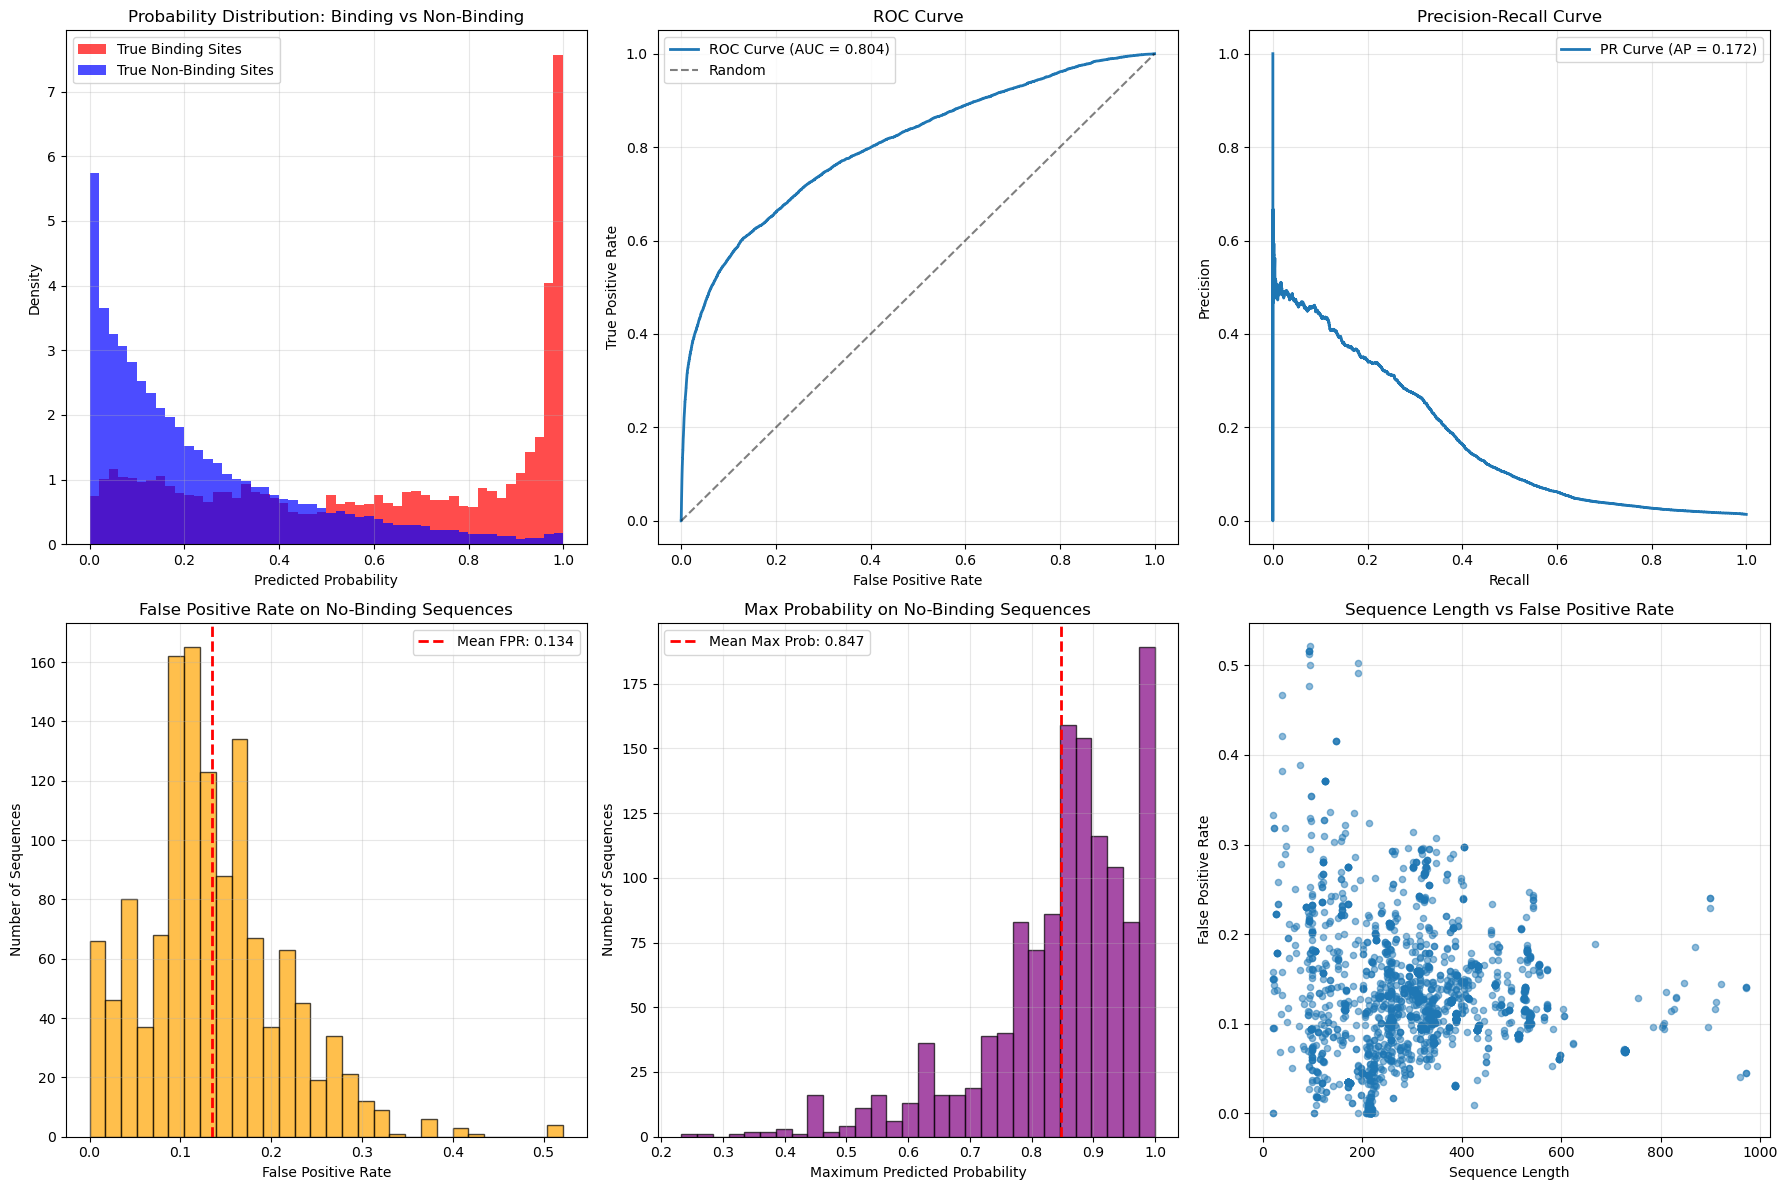

In [ ]:
# For comprehensive evaluation on test split
evaluator, metrics = run_comprehensive_evaluation(
    model_path='best_binding_model.pth',
    csv_file=CSV_FILE,
    subset_size=1000
)

# For final evaluation on ALL test data
#final_evaluator, final_metrics = final_test_evaluation(
#    model_path='best_binding_model.pth',
#    csv_file='merged_protein_dataset.csv'
#)

In [ ]:
def load_sequences_from_csv(csv_file, num_sequences=10, min_length=50, max_length=500, random_seed=42):
    """Load sequences and their true binding labels from CSV file."""
    print(f"Loading sequences from {csv_file} (TEST split only)...")
    
    # Load TEST dataset - ensures we're using held-out 10%
    test_dataset = BioLiPDataset(csv_file, max_length=1000, min_length=20, split='test')
    
    print(f"Test dataset loaded: {len(test_dataset)} sequences from {len(test_dataset.get_pdb_ids())} PDB structures")
    
    # Filter for good visualization examples
    np.random.seed(random_seed)
    
    # Find sequences with different binding patterns
    sequences_with_binding = []
    sequences_without_binding = []

    for i in range(len(test_dataset)):
        binding_labels = test_dataset.binding_labels[i]
        binding_ratio = sum(binding_labels) / len(binding_labels)
        
        if binding_ratio > 0.05:  # Has meaningful binding sites
            sequences_with_binding.append((i, binding_ratio))
        else:  # No or very few binding sites
            sequences_without_binding.append((i, binding_ratio))
    
    print(f"Found {len(sequences_with_binding)} sequences with binding, {len(sequences_without_binding)} without")
    
    # Sample diverse examples
    selected_indices = []
    
    # Get sequences with binding (sorted by binding ratio for variety)
    if sequences_with_binding:
        sequences_with_binding.sort(key=lambda x: x[1], reverse=True)
        with_binding_sample = min(num_sequences // 2, len(sequences_with_binding))
        step = max(1, len(sequences_with_binding) // with_binding_sample)
        selected_indices.extend([sequences_with_binding[i*step][0] for i in range(with_binding_sample)])
    
    # Get sequences without binding
    if sequences_without_binding:
        without_binding_sample = num_sequences - len(selected_indices)
        if without_binding_sample > 0:
            without_indices = np.random.choice([x[0] for x in sequences_without_binding], 
                                              size=min(without_binding_sample, len(sequences_without_binding)), 
                                              replace=False)
            selected_indices.extend(without_indices)
    
    # Load selected sequences
    evaluation_data = []
    for idx in selected_indices[:num_sequences]:
        seq_data = test_dataset[idx]
        sequence = ''.join([list(AA_TO_IDX.keys())[i] for i in seq_data['sequence'].numpy() if i < 20])
        true_labels = seq_data['labels'].numpy()
        metadata = seq_data['metadata']
        
        evaluation_data.append({
            'sequence': sequence,
            'true_labels': true_labels,
            'metadata': metadata,
            'dataset_index': idx
        })
    
    print(f"Selected {len(evaluation_data)} sequences for visualization (from TEST split)")
    return evaluation_data



def create_sequence_comparison_plot(sequence_data, predicted_probs, save_path=None, figsize=(15, 8)):
    """Create a detailed comparison plot for a single sequence."""
    sequence = sequence_data['sequence']
    true_labels = sequence_data['true_labels']
    metadata = sequence_data['metadata']
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, height_ratios=[2, 1, 1])
    
    positions = np.arange(1, len(sequence) + 1)
    
    # Top plot: Predicted probabilities as line plot
    ax1.plot(positions, predicted_probs, linewidth=2, color='blue', alpha=0.8, label='Predicted Probability')
    ax1.fill_between(positions, predicted_probs, alpha=0.3, color='blue')
    
    # Add threshold line
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold (0.5)')
    
    # Highlight true binding sites
    true_binding_positions = positions[true_labels == 1]
    if len(true_binding_positions) > 0:
        ax1.scatter(true_binding_positions, predicted_probs[true_labels == 1], 
                   color='red', s=30, alpha=0.8, zorder=5, label='True Binding Sites')
    
    ax1.set_ylabel('Predicted Probability', fontsize=12)
    ax1.set_title(f'Binding Site Prediction vs Ground Truth\n'
                  f'PDB: {metadata["pdb_id"]}, Chain: {metadata["chain"]}, '
                  f'Ligand: {metadata["ligand_name"]}\n'
                  f'Length: {len(sequence)} residues', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Middle plot: True binding sites as bars
    ax2.bar(positions, true_labels, width=1.0, color='red', alpha=0.7, edgecolor='darkred')
    ax2.set_ylabel('True\nBinding', fontsize=10)
    ax2.set_ylim(0, 1.2)
    ax2.set_yticks([0, 1])
    ax2.grid(True, alpha=0.3)
    
    # Bottom plot: Predicted binding sites as bars (threshold = 0.5)
    predicted_binary = (predicted_probs > 0.5).astype(int)
    ax3.bar(positions, predicted_binary, width=1.0, color='blue', alpha=0.7, edgecolor='darkblue')
    ax3.set_ylabel('Predicted\nBinding', fontsize=10)
    ax3.set_xlabel('Residue Position', fontsize=12)
    ax3.set_ylim(0, 1.2)
    ax3.set_yticks([0, 1])
    ax3.grid(True, alpha=0.3)
    
    # Add sequence annotation at bottom
    if len(sequence) <= 100:  # Only show sequence if not too long
        seq_text = ''.join([f'{aa}{i+1:3d}' if (i+1) % 10 == 0 else aa for i, aa in enumerate(sequence)])
        ax3.text(0.02, -0.15, f'Sequence: {sequence[:100]}{"..." if len(sequence) > 100 else ""}', 
                transform=ax3.transAxes, fontsize=8, fontfamily='monospace')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def create_overview_comparison_plot(all_results, save_path='evaluation_overview.png'):
    """Create an overview plot comparing multiple sequences."""
    num_sequences = len(all_results)
    fig, axes = plt.subplots(num_sequences, 1, figsize=(15, 3*num_sequences), 
                            sharex=False)
    
    if num_sequences == 1:
        axes = [axes]
    
    for i, result in enumerate(all_results):
        ax = axes[i]
        sequence = result['sequence_data']['sequence']
        true_labels = result['sequence_data']['true_labels']
        predicted_probs = result['predicted_probs']
        metadata = result['sequence_data']['metadata']
        
        positions = np.arange(1, len(sequence) + 1)
        
        # Plot predictions and ground truth
        ax.plot(positions, predicted_probs, linewidth=2, color='blue', alpha=0.8, label='Predicted')
        ax.fill_between(positions, predicted_probs, alpha=0.2, color='blue')
        
        # FIX: Convert sum to integer
        if sum(true_labels) > 0:  # Only plot if there are binding sites
            ax.bar(positions[true_labels == 1], np.ones(int(sum(true_labels))), 
                  width=1.0, color='red', alpha=0.6, label='True Binding')
        
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        
        # Calculate metrics for this sequence
        pred_binary = (predicted_probs > 0.5).astype(int)
        tp = sum((pred_binary == 1) & (true_labels == 1))
        fp = sum((pred_binary == 1) & (true_labels == 0))
        fn = sum((pred_binary == 0) & (true_labels == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        ax.set_title(f'#{i+1}: {metadata["pdb_id"]}-{metadata["chain"]} | '
                    f'Length: {len(sequence)} | True Sites: {int(sum(true_labels))} | '  # FIX: Convert to int
                    f'F1: {f1:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}', 
                    fontsize=10)
        ax.set_ylabel('Probability', fontsize=9)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.legend()
    
    axes[-1].set_xlabel('Residue Position', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def run_csv_evaluation(model_path='best_binding_model.pth', 
                      csv_file='merged_protein_dataset.csv',
                      num_sequences=8,
                      detailed_plots=True):
    """Run comprehensive evaluation using sequences from CSV file TEST split."""
    
    # Load model
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    model = load_trained_model(model_path, device)
    
    # Load sequences from CSV TEST split - FIX: Pass csv_file parameter
    evaluation_data = load_sequences_from_csv(csv_file, num_sequences=num_sequences)
    
    # Get predictions for all sequences
    all_results = []
    
    print("Getting predictions on TEST sequences...")
    for i, seq_data in enumerate(tqdm(evaluation_data)):
        sequence = seq_data['sequence']
        
        # Get model prediction
        result = predict_binding_sites(model, sequence, device=device)
        predicted_probs = np.array(result['per_residue_scores'])
        
        all_results.append({
            'sequence_data': seq_data,
            'predicted_probs': predicted_probs,
            'prediction_result': result
        })
        
        # Create detailed plot for each sequence if requested
        if detailed_plots and i < 3:  # Limit detailed plots to first 3
            save_path = f'detailed_comparison_TEST_seq_{i+1}.png'  # Clear filename
            create_sequence_comparison_plot(seq_data, predicted_probs, save_path)
            print(f"Detailed plot saved: {save_path}")
    
    # Create overview plot
    create_overview_comparison_plot(all_results, save_path='evaluation_overview_TEST.png')  # Clear filename
    
    # Print summary statistics
    print_csv_evaluation_summary(all_results)
    
    return all_results



def print_csv_evaluation_summary(all_results):
    """Print summary statistics for CSV evaluation."""
    print("\n" + "="*80)
    print("CSV EVALUATION SUMMARY")
    print("="*80)
    
    all_f1_scores = []
    all_precisions = []
    all_recalls = []
    sequences_with_binding = 0
    sequences_without_binding = 0
    
    for i, result in enumerate(all_results):
        true_labels = result['sequence_data']['true_labels']
        predicted_probs = result['predicted_probs']
        metadata = result['sequence_data']['metadata']
        
        pred_binary = (predicted_probs > 0.5).astype(int)
        
        tp = sum((pred_binary == 1) & (true_labels == 1))
        fp = sum((pred_binary == 1) & (true_labels == 0))
        fn = sum((pred_binary == 0) & (true_labels == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        has_binding = sum(true_labels) > 0
        if has_binding:
            sequences_with_binding += 1
            all_f1_scores.append(f1)
            all_precisions.append(precision)
            all_recalls.append(recall)
        else:
            sequences_without_binding += 1
        
        # FIX: Convert float counts to integers for formatting
        print(f"Seq {i+1:2d}: {metadata['pdb_id']}-{metadata['chain']:>2} | "
              f"Length: {len(true_labels):3d} | True sites: {int(sum(true_labels)):2d} | "
              f"Pred sites: {int(sum(pred_binary)):2d} | F1: {f1:.3f}")
    
    if all_f1_scores:
        print(f"\nOverall Performance on sequences with binding:")
        print(f"  Mean F1-Score:  {np.mean(all_f1_scores):.4f} ± {np.std(all_f1_scores):.4f}")
        print(f"  Mean Precision: {np.mean(all_precisions):.4f} ± {np.std(all_precisions):.4f}")
        print(f"  Mean Recall:    {np.mean(all_recalls):.4f} ± {np.std(all_recalls):.4f}")
    
    print(f"\nDataset Composition:")
    print(f"  Sequences with binding sites: {sequences_with_binding}")
    print(f"  Sequences without binding sites: {sequences_without_binding}")

In [34]:
# Run the evaluation
results = run_csv_evaluation(
    model_path='best_binding_model.pth',
    csv_file=CSV_FILE,
    num_sequences=8,
    detailed_plots=True
)

/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/637138005.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

Loaded model with validation F1: 0.3420
Loading sequences from merged_protein_dataset.csv...


/var/folders/0z/k6q38q1x0952659gqgnv1n380000gn/T/ipykernel_19729/3869039191.py:60: DtypeWarning: Columns (163,165,166,167,205,207,208,209,211,213,214,215,217,219,220,221,223,225,226,227,229,231,232,233,235,237,238,239,247,249,250,251,259,261,262,263,265,267,268,269,271,273,274,275,277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,302,304,305,306,308,309,310,311,312,314,315,317,318,319,320,321,322,324,329,332,333,334,335,336,337,339,341,342,343,345,346,348,350,351,352,353,355,356,359,361,362,363,365,367,368,369,372,373,374,376,377,378,379,382,383,385) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv(csv_file)


Dataset split info:
  Total PDB entries: 14955
  Train PDB entries: 13460 (90.0%)
  Test PDB entries: 1495 (10.0%)
  Loading: test split (3800 rows)


Processing sequences:  49%|████▉     | 1863/3800 [00:01<00:01, 1168.98it/s]


KeyboardInterrupt: 